In [182]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import time

import shap

from sklearn.decomposition import PCA


## Load data and set time frame

In [2]:
dfcombo = pd.read_csv('combo.csv')
# dfcombo.describe().T

In [3]:
timeperiod_for_analysis = 'pct_next_1yr'    # can also look at 2 years out, or 3 years out, ...

## add columns

In [4]:
# there are no null states, and all are two letters long. Encode as ints for random forest, etc. But category. 
encoder = LabelEncoder()
dfcombo['state_encoded'] = encoder.fit_transform(dfcombo['state'])
dfcombo['state_encoded'] = dfcombo['state_encoded'].astype('category')

In [5]:
# 3 years stood out when doing EDA. 1-hot encode those years for linear regression, logistic, SGD
years_to_encode = [2019, 2020, 2021]
for year in years_to_encode:
    dfcombo[f'year_{year}'] = (dfcombo['year'] == year).astype(int)

In [6]:
# for some models like RandomForest & lightGBM, I can also just set year to category
dfcombo['year'] = dfcombo['year'].astype('category')

For classification we will use a binary column named 'winner'. A zip code is a winner for a given year if it performs better than the weighted average for that year. I'll do weighted average by population -- an alternative is to do it by num_units.

In [7]:
dfcombo['weighted_avg'] = (dfcombo['population'] * dfcombo[timeperiod_for_analysis]).groupby(dfcombo['year']).transform('sum') / dfcombo['population'].groupby(dfcombo['year']).transform('sum')
dfcombo['winner'] = dfcombo.apply(lambda x: 1 if x[timeperiod_for_analysis] > x['weighted_avg'] else 0, axis=1)
print("Weighted Average price increases:")
print(dfcombo.groupby('year')['weighted_avg'].first())
print("\nCounts for each 'winner' value:")
print(dfcombo['winner'].value_counts())

Weighted Average price increases:
year
2012    0.093404
2013    0.059667
2014    0.065022
2015    0.056611
2016    0.068893
2017    0.065557
2018    0.046874
2019    0.095980
2020    0.147883
2021    0.087071
Name: weighted_avg, dtype: float64

Counts for each 'winner' value:
0    128435
1     88889
Name: winner, dtype: int64


In [8]:
# any always winners? zip codes that are better than average EVERY year
grouped = dfcombo.groupby('zipcode').agg(total_win=('winner', 'sum'), count_years=('year', 'size'))
winning_zipcodes = grouped[grouped['total_win'] == grouped['count_years']].index.tolist()

print(len(winning_zipcodes))

# create a column for that
dfcombo['always_winner'] = 0
dfcombo.loc[dfcombo['zipcode'].isin(winning_zipcodes), 'always_winner'] = 1

581


## organize features
Categorize the features. Every column in dfcombo should be in a single category list below. The purpse of these lists is to keep things organized and to facilitate later work.

In [9]:
# dfcombo.columns.tolist()

In [10]:
not_in_models = ['zipcode',
                 'year',        # used to calculate 1-hot encoded, like year_2019
                 'state',       # use state_encoded instead
                 'city',        # too granular for now
                 'metro',       # too granular for now
                 'county',      # too granular for now
                 'typ_price',   # used to calculate pct_next_1yr etc
                 'weighted_avg' # used to calculate 'winner' column
                ]

potential_dependent_vars = [
    'winner',
    'always_winner',
'pct_next_1yr',
 'pct_next_2yr',
 'pct_next_3yr',
 'pct_next_4yr',
 'pct_next_5yr',
 'pct_next_6yr',
 'pct_next_7yr',
 'pct_next_8yr',
 'pct_next_9yr',
 'pct_next_10yr',    
]

categorical = ['state_encoded', # categorical, will not be used in logistic regression, etc
              ]

one_hot = ['year_2019',
 'year_2020',
 'year_2021'    
]

for_scaler = ['population',
              'median_household_income',
              'median_age',
              'median_rent',
              'mean_travel_time_to_work',
              'median_value',
              'ave_num_rooms',
              'median_RE_tax',
              'peops_per_household',
              
              
             ]
zero_to_one = ['gini',
 'cost_of_living_perc',
'labor_force_perc',
'unemployed_perc',
'bach_degr_perc',
'masters_degr_perc',               
'owner_occ_perc',
'new_units_perc',
'families_wU18_perc',
'poverty_perc',
'non_families_perc',
'vacant_perc',
'perc_moved_fr_same_county',
'perc_moved_fr_other_county',
 'perc_moved_fr_other_state',
 'perc_moved_fr_abroad',
 'single_fam_perc',
 'public_trans_perc',
 'foreign_born_perc',
 'male_perc',
              ]

In [11]:
# verify the above lists are complete, and with no duplicates
def verify_lists(sublists, orig):
    # Helper function to find duplicates withiin a list
    def has_duplicates(lst):
        return len(lst) != len(set(lst))
    
    # 1. Check for duplicates within individual lists
    for lst in sublists:
        if has_duplicates(lst):
            return f"A sub list has duplicates."
    
    # 2. Verify sum of sublists = orig
    combined = [item for sublist in sublists for item in sublist]

    missing_in_compare = set(combined) - set(orig)
    extra_in_compare = set(orig) - set(combined)   
    if missing_in_compare:
        print(f"Items in combined that are not in compare_list: {missing_in_compare}")
    if extra_in_compare:
        print(f"Items in compare_list that are not in combined: {extra_in_compare}")
    
    # 3. Check for duplicates in combined lists
    if has_duplicates(combined):
        return "Combined msublists have duplicates."
    
    return "check complete."

In [12]:
verify_lists([not_in_models, potential_dependent_vars, categorical, one_hot, for_scaler, zero_to_one], 
             dfcombo.columns.tolist())

'check complete.'

The features will vary depending on the type of the model. Also, some features need to be scaled.

'dfB' is the same as 'dfA' except it adds categorical features

## prepare data: X, y, StandardScaler, KFold

In [13]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(dfcombo[for_scaler]), columns=for_scaler, index=dfcombo.index)
dfA = pd.concat([df_scaled, dfcombo[one_hot], dfcombo[zero_to_one]], axis=1)
dfB = pd.concat([dfA, dfcombo[categorical]], axis=1)
yboth = dfcombo['winner']

In [14]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(dfA, yboth, test_size=0.3, random_state=42)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(dfB, yboth, test_size=0.3, random_state=42)

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# function to calculate number of parameter combinations
# it only works of all of the dictionary values are lists.
# If there is an empty list this will return zero
def count_combinations(params):
    combos = 1
    for value_list in params.values():
        combos *= len(value_list)
    return combos
        

## Classification setup

In [17]:
scoring = 'accuracy'

In [186]:
def print_clf_summaries(fitted_grid_search, doD=True):
    print("Best parameters found: ", grid_search.best_params_)

    # A. get mean   of training accuracy (values from each fold) for best param combo
    # B. get mean   of test     accuracy (values from each fold) for best param combo       FOR REPORT
    # C. get stdDev of test     accuracy (values from each fold) for best param combo       FOR REPORT
    print("A.   Mean of training acc. for the best model: {:.4f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]))
    print("B.   Mean of test accuracy for the best model: {:.4f} <---REPORT".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))
    print("C. StdDev of test accuracy for the best model: {:.4f} <---REPORT".format(grid_search.cv_results_['std_test_score'][grid_search.best_index_]))    

    # get predictions and validation accuracy
    if doD:
        y_pred = grid_search.predict(Xtst)
        print("validation accuracy: {:.4f}".format(accuracy_score(ytst, y_pred)))    

## logistic regression

In [99]:
# set everything up
Xtrn, Xtst, ytrn, ytst = Xa_train, Xa_test, ya_train, ya_test   # A: no categorical, B: yes categorical

params = {
   'penalty': ['l2'],        # default=l2
   'C': [.1, 1, 10],      # default=1
    'max_iter': [100, 1000],       # default = 100
}
clf = LogisticRegression()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 6


In [100]:
# fit
grid_search.fit(Xtrn, ytrn)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 1000],
                         'penalty': ['l2']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [101]:
print_clf_summaries(grid_search)

Best parameters found:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
A.   Mean of training acc. for the best model: 0.6464
B.   Mean of test accuracy for the best model: 0.6461 <---REPORT
C. StdDev of test accuracy for the best model: 0.0021 <---REPORT
validation accuracy: 0.6466


if A >> B then overfitting

In [102]:
# get predictions and validation accuracy
y_pred = grid_search.predict(Xtst)
print("validation accuracy: {:.4f}".format(accuracy_score(ytst, y_pred)))

validation accuracy: 0.6466


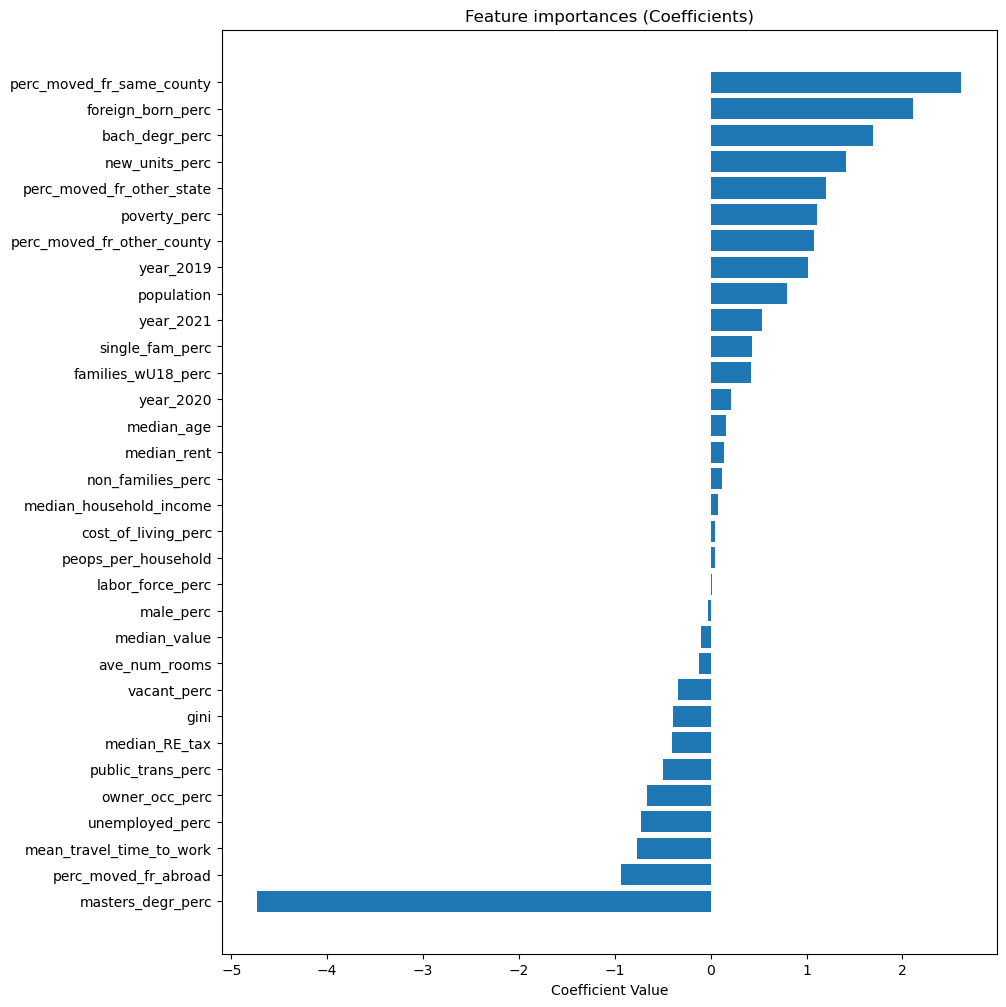

In [104]:
best_logreg = grid_search.best_estimator_
coefficients = best_logreg.coef_[0]
feature_names = Xtrn.columns

# Sort features based on coefficient values
sorted_idx = coefficients.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), coefficients[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Coefficient Value')
plt.title('Feature importances (Coefficients)')
plt.show()


## Random Forest Classifier

In [35]:
# set everything up
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical

params = {
    'random_state': [42],
    'max_features': ['sqrt', 10],     # def = sqrt
    'n_estimators': [50, 100],        # def = 100
    'max_depth': [20, None],          # def = None
}
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 8


In [33]:
# fit
grid_search.fit(Xtrn, ytrn)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None], 'max_features': ['sqrt'],
                         'n_estimators': [100], 'random_state': [42]},
             return_train_score=True, scoring='accuracy')

In [34]:
print_clf_summaries(grid_search)

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}
A.   Mean of training acc. for the best model: 1.0000
B.   Mean of test accuracy for the best model: 0.7244
C. StdDev of test accuracy for the best model: 0.0024
validation accuracy: 0.7283


## lightGBM

In [45]:
# set everything up
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical

params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [31, 100],             # default = 31
    'learning_rate': [0.05, 0.1],        # default=0.1
    'max_depth': [10, -1],               # def = -1
    'n_estimators': [50, 100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 16


In [46]:
# fit
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you did

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409561 -> initscore=-0.365780
[LightGBM] [Info] Start training from s

[LightGBM] [Info] Number of positive: 49744, number of negative: 71957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408739 -> initscore=-0.369179
[LightGBM] [Info] Start training from score -0.369179
[LightGBM] [Info] Number of positive: 49787, number of negative: 71914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7270
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 49787, number of negative: 71914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7270
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409093 -> initscore=-0.367717
[LightGBM] [Info] Start training from score -0.367717
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You ca

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (n

[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409561 -> initscore=-0.365780
[LightGBM] [Info] Start training from score -0.365780
[LightGBM] [Info] Number of positive: 49623, number of negative: 72078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407745 -> initscore=-0.373294
[LightGBM] [Info] Start training from score -0.373294
[LightGBM]

[LightGBM] [Info] Number of positive: 49623, number of negative: 72078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407745 -> initscore=-0.373294
[LightGBM] [Info] Start training from score -0.373294
[LightGBM] [Info] Number of positive: 49744, number of negative: 71957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408739 -> initscore=-0.369179
[LightGBM] [Info] Start training from score -0.369179
[LightGBM]

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [10, -1],
                         'n_estimators': [50, 100], 'num_leaves': [31, 100],
                         'objective': ['binary'], 'random_state': [42]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [47]:
print_clf_summaries(grid_search)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
A.   Mean of training acc. for the best model: 0.7975
B.   Mean of test accuracy for the best model: 0.7531 <---REPORT
C. StdDev of test accuracy for the best model: 0.0020 <---REPORT
validation accuracy: 0.7523


One experiment: num_leaves 31 -> .7470, 100 -> .7531

## KNN Classifier

In [50]:
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical

params = {
    'n_neighbors': [3, 5, 9],    # def = 5
    'metric': ['minkowski'],    # def = minkowski
}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 3


In [51]:
# fit
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Total runtime: 128.12 seconds


In [52]:
print_clf_summaries(grid_search)

Best parameters found:  {'metric': 'minkowski', 'n_neighbors': 9}
A.   Mean of training acc. for the best model: 0.7640
B.   Mean of test accuracy for the best model: 0.7005 <---REPORT
C. StdDev of test accuracy for the best model: 0.0034 <---REPORT
validation accuracy: 0.7048


## Gaussian Naive Bayes

In [55]:
Xtrn, Xtst, ytrn, ytst = Xa_train, Xa_test, ya_train, ya_test   # A: no categorical, B: yes categorical
params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]  # default 1e-9
}
clf = GaussianNB()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 6


In [56]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Total runtime: 2.03 seconds


In [57]:
print_clf_summaries(grid_search)

Best parameters found:  {'var_smoothing': 0.0001}
A.   Mean of training acc. for the best model: 0.6215
B.   Mean of test accuracy for the best model: 0.6211 <---REPORT
C. StdDev of test accuracy for the best model: 0.0033 <---REPORT
validation accuracy: 0.6231


## SGD Classifier

In [58]:
Xtrn, Xtst, ytrn, ytst = Xa_train, Xa_test, ya_train, ya_test   # A: no categorical, B: yes categorical
params = {
    'max_iter': [1000, 2000],  # default 1000
    'tol': [1e-2, 1e-3, 1e-4],  # default 1e-3
}
clf = SGDClassifier()

grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=1)
print('parameter combinations:', count_combinations(params))

parameter combinations: 6


In [59]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Total runtime: 41.71 seconds


In [60]:
print_clf_summaries(grid_search)

Best parameters found:  {'max_iter': 2000, 'tol': 0.0001}
A.   Mean of training acc. for the best model: 0.6362
B.   Mean of test accuracy for the best model: 0.6362 <---REPORT
C. StdDev of test accuracy for the best model: 0.0096 <---REPORT
validation accuracy: 0.6449


## Feature importance

In [107]:
# redo light GBM witth best parameters
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical


# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [100],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [108]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409561 -> initscore=-0.365780


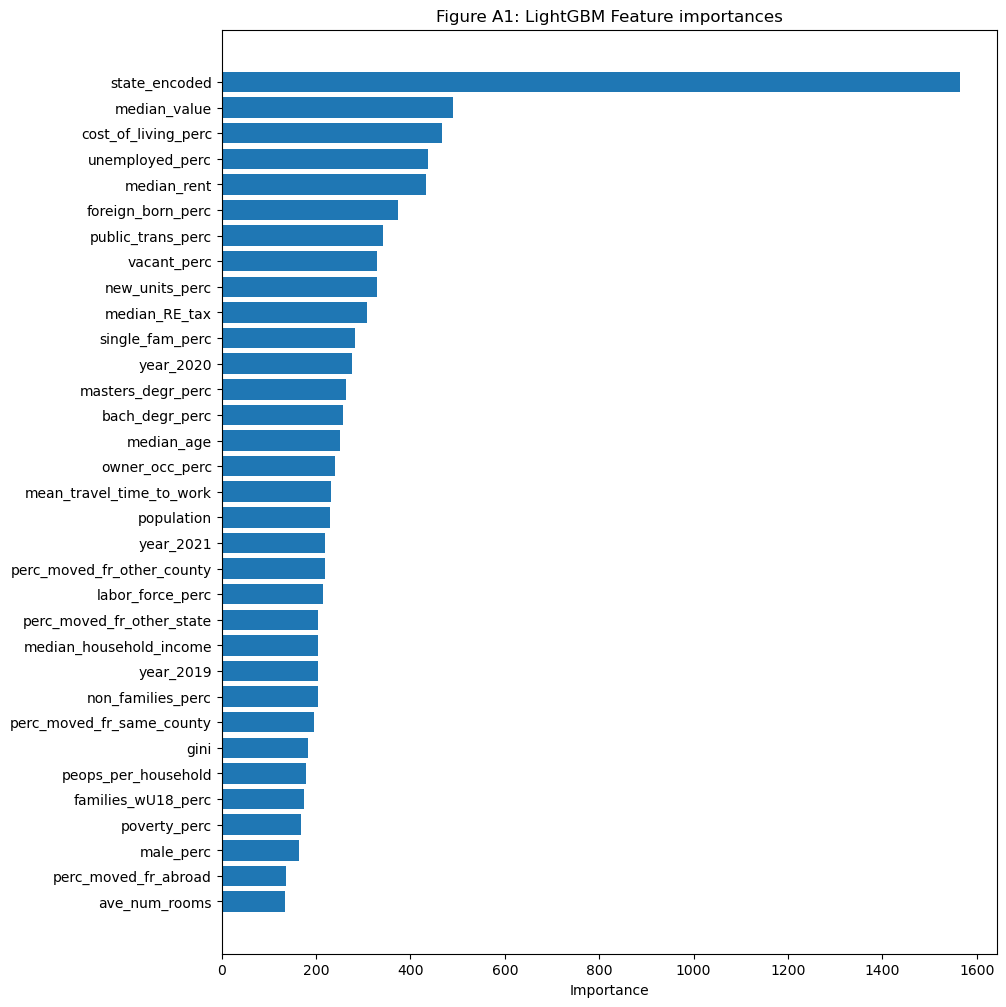

In [109]:
best_lgbm = grid_search.best_estimator_
importances = best_lgbm.feature_importances_
import matplotlib.pyplot as plt

# Assuming you have a list of feature names, for example from a DataFrame
feature_names = Xtrn.columns 

# Sort features based on importance
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Figure A1: LightGBM Feature importances')
plt.show()

In [78]:
explainer = shap.TreeExplainer(best_lgbm)


In [79]:
shap_values = explainer.shap_values(Xtst)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [80]:
# I just need the results for the positive class
shap_values = shap_values[1]

In [81]:
state_encoded_idx = feature_names.get_loc('state_encoded')

In [82]:
state_encoded_shap = shap_values[:, state_encoded_idx]

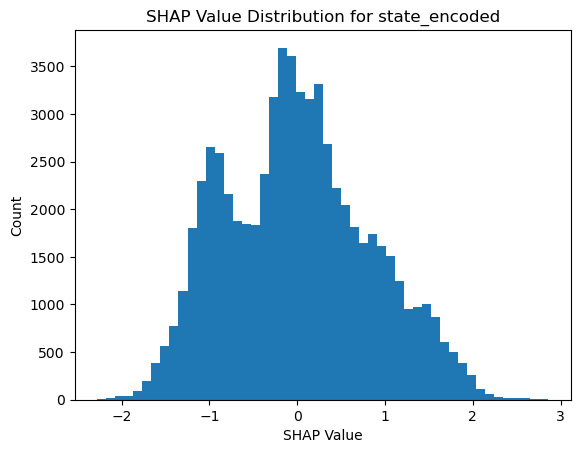

In [83]:
# You can then plot the distribution of SHAP values for state_encoded
plt.hist(state_encoded_shap, bins=50)
plt.xlabel('SHAP Value')
plt.ylabel('Count')
plt.title('SHAP Value Distribution for state_encoded')
plt.show()

In [95]:
# dfcombo[['state_encoded']]

## feature importance without state_encoded (sensitivity 1)

In [96]:
# rerun without state
Xtrn, Xtst, ytrn, ytst = Xa_train, Xa_test, ya_train, ya_test   # A: no categorical, B: yes categorical


# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [100],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [97]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7218
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7218
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 32
[LightGBM] [Info

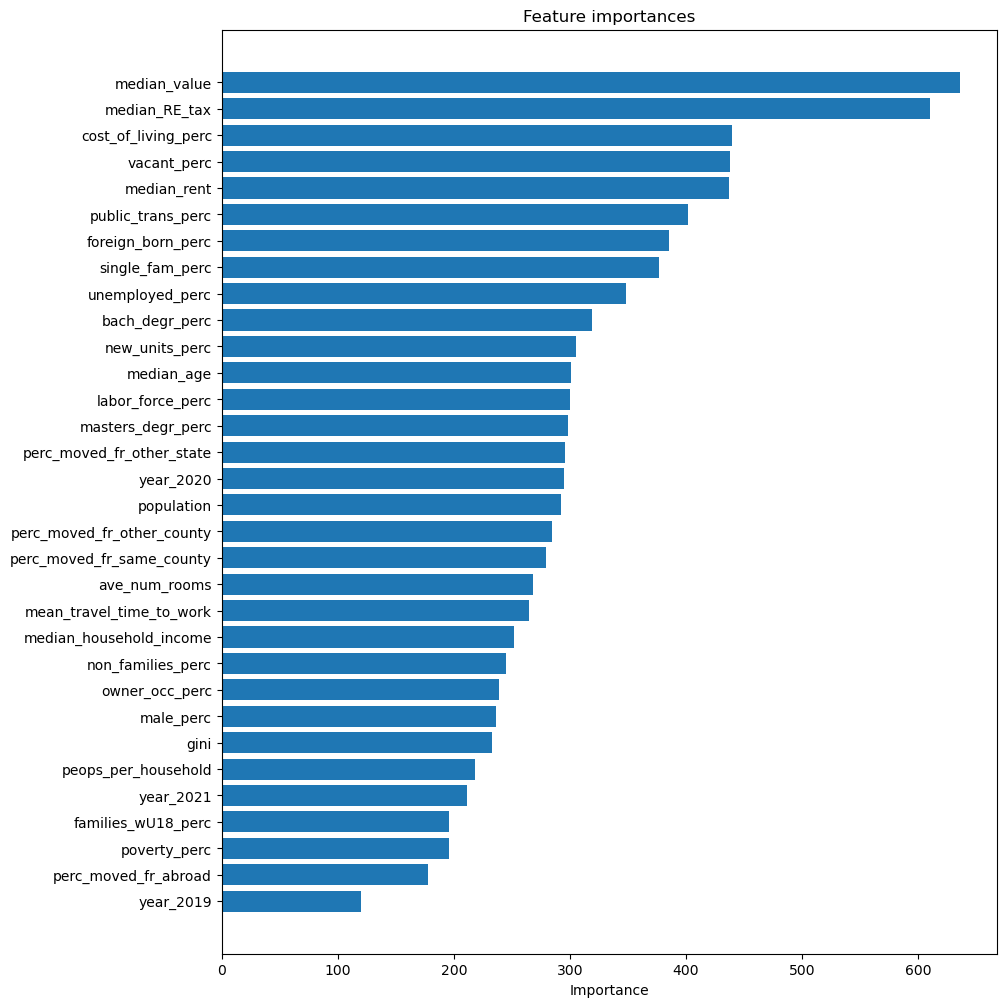

In [98]:
best_lgbm = grid_search.best_estimator_
importances = best_lgbm.feature_importances_
import matplotlib.pyplot as plt

# Assuming you have a list of feature names, for example from a DataFrame
feature_names = Xtrn.columns 

# Sort features based on importance
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.show()

In [ ]:
# its diffifult to generate the state coeffciients from lightGBT. But we can easily look at distributions by state:


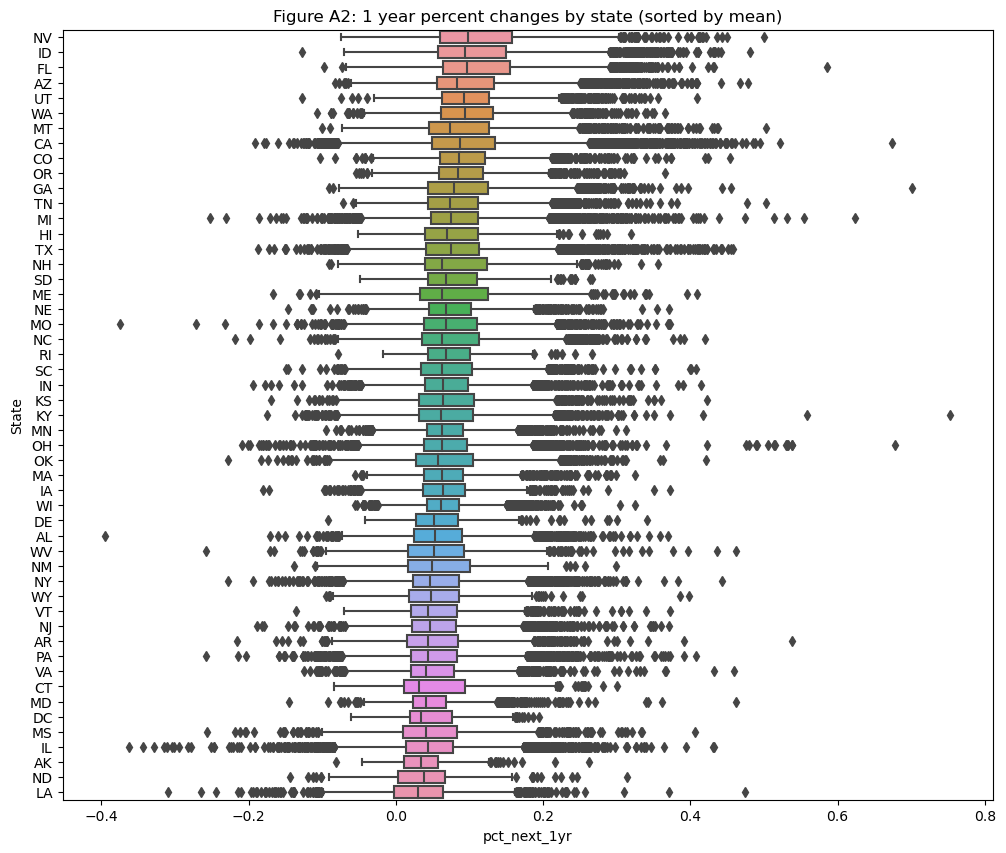

In [110]:
state_order = dfcombo.groupby('state')['pct_next_1yr'].mean().sort_values(ascending=False).index

# box plot sorted by the mean value of 'pct_next_1yr'
plt.figure(figsize=(12, 10))
sns.boxplot(data=dfcombo, x='pct_next_1yr', y='state', order=state_order)
plt.title('Figure A2: 1-year percent changes by state (sorted by mean)')
plt.xlabel('pct_next_1yr')
plt.ylabel('State')
plt.show()


## Sensitivity 2: varying num_leaves

In [111]:
# redo light GBM witth best parameters
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical

# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
num_leaves_values = [5, 10, 20, 40, 80, 150, 200]
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': num_leaves_values,             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True)
print('parameter combinations:', count_combinations(params))

parameter combinations: 7


In [112]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409561 -> initscore=-0.365780


[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

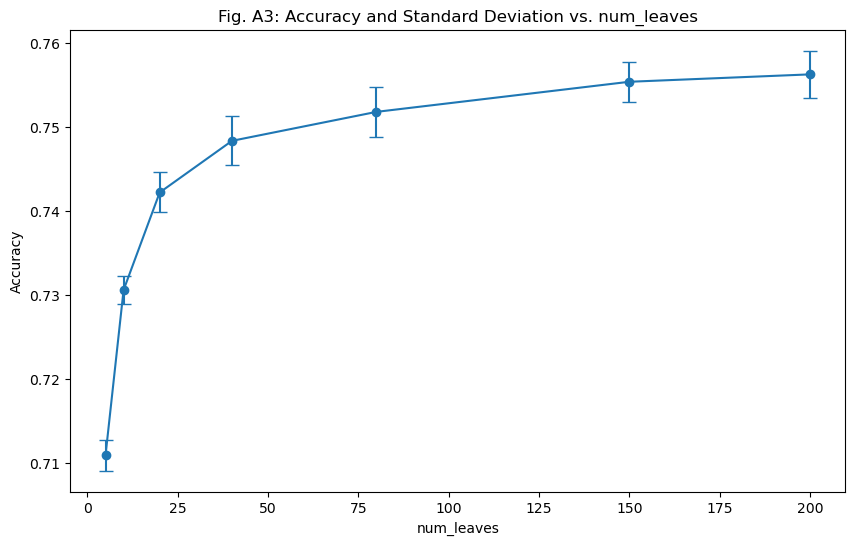

In [116]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
std_test_scores = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(10, 6))
plt.errorbar(num_leaves_values, mean_test_scores, yerr=std_test_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('num_leaves')
plt.ylabel('Accuracy')
plt.title('Fig. A3: Accuracy and Standard Deviation vs. num_leaves')
plt.show()


In [117]:
mean_test_scores

array([0.71084497, 0.7305326 , 0.74215455, 0.74830078, 0.75175186,
       0.75533441, 0.75621526])

<Axes: >

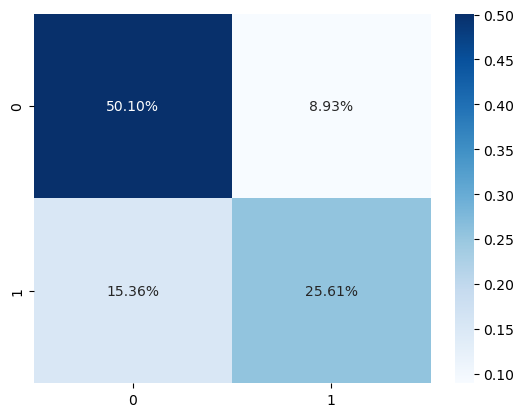

In [125]:
y_pred = grid_search.best_estimator_.predict(Xtst)
cm = confusion_matrix(ytst, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')m

## trade-offs

In [129]:
# try speed and accuracy: use num leaves
# redo light GBM witth best parameters
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical


# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [200],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [130]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 49844, number of negative: 7

In [13]:
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(dfcombo[for_scaler]), columns=for_scaler, index=dfcombo.index)
# dfA = pd.concat([df_scaled, dfcombo[one_hot], dfcombo[zero_to_one]], axis=1)
# dfB = pd.concat([dfA, dfcombo[categorical]], axis=1)
# yboth = dfcombo['winner']

In [131]:
dfB.shape

(217324, 33)

In [132]:
yboth.shape

(217324,)

In [141]:
dfC = pd.concat([dfB, yboth], axis=1)
dfC.shape

(217324, 34)

In [142]:
dfC = dfC.sample(frac=0.5, random_state=42)
dfC.shape

(108662, 34)

In [143]:
y2 = dfC['winner']
dfC = dfC.iloc[:, :-1]
dfC.shape

(108662, 33)

In [144]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(dfC, y2, test_size=0.3, random_state=42)

In [145]:
Xtrn, Xtst, ytrn, ytst = Xc_train, Xc_test, yc_train, yc_test   # C: yes categorical, 50% of rows


# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [80],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [146]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 24940, number of negative: 35910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7267
[LightGBM] [Info] Number of data points in the train set: 60850, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409860 -> initscore=-0.364543
[LightGBM] [Info] Start training from score -0.364543
[LightGBM] [Info] Number of positive: 24977, number of negative: 35873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7265
[LightGBM] [Info] Number of data points in the train set: 60850, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410468 -> initscore=-0.362030
[L

## Failure Analysis (original best model)

In [147]:
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical


# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [100],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [148]:
start_time = time.time()
grid_search.fit(Xtrn, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7269
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 33
[LightGBM] [Info

In [149]:
    print("B.   Mean of test accuracy for the best model: {:.4f} <---REPORT".format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))
    print("C. StdDev of test accuracy for the best model: {:.4f} <---REPORT".format(grid_search.cv_results_['std_test_score'][grid_search.best_index_]))    

    # get predictions and validation accuracy
    y_pred = grid_search.predict(Xtst)
    print("validation accuracy: {:.4f}".format(accuracy_score(ytst, y_pred)))    

B.   Mean of test accuracy for the best model: 0.7531 <---REPORT
C. StdDev of test accuracy for the best model: 0.0020 <---REPORT
validation accuracy: 0.7523


In [180]:
mismatches = y_pred != ytst
X_mismatched = Xtst[mismatches]
y_mismatched_true = ytst[mismatches]
y_mismatched_pred = y_pred[mismatches]
# print(X_mismatched.head())
# print("\nTrue Values:\n", y_mismatched_true.head())
# print("\nPredicted Values:\n", y_mismatched_pred[:5])

In [167]:
print(len(mismatches))
print(len(X_mismatched))
print(len(y_mismatched_true))
print(len(y_mismatched_pred))
y_mismatched_true.head(5)

print(type(X_mismatched))
print(type(y_mismatched_true))
print(type(y_mismatched_pred))


65198
16148
16148
16148
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [165]:
y_mismatched_pred[0:5]


array([0, 0, 1, 0, 0])

In [169]:
mism = X_mismatched.copy()
mism['pred'] = y_mismatched_pred
mism['true'] = y_mismatched_true
mism.shape

(16148, 35)

In [170]:
mism.loc[[116628]]

,population,median_household_income,median_age,median_rent,mean_travel_time_to_work,median_value,ave_num_rooms,median_RE_tax,peops_per_household,year_2019,...,perc_moved_fr_other_county,perc_moved_fr_other_state,perc_moved_fr_abroad,single_fam_perc,public_trans_perc,foreign_born_perc,male_perc,state_encoded,pred,true
116628,-0.722366,0.560196,-0.149262,-0.38402,-0.700993,-0.391255,0.081742,-0.137176,0.268394,0,...,0.05303,0.011183,0.0,0.900398,0.0,0.00469,0.47619,12,0,1


In [171]:
mism2 = dfcombo.join(mism[['pred', 'true']], how='inner')

In [175]:
mism2['delta_perc'] = mism2['pct_next_1yr'] - mism2['weighted_avg']
mism2['delta_perc_abs'] = abs(mism2['delta_perc'])

In [179]:
mism2.sample(8, random_state=42).T

,143860,96526,17094,120450,16574,51196,211089,83831
zipcode,72461,91784,76262,67335,85715,47611,67752,20783
year,2018,2016,2012,2017,2012,2014,2021,2016
population,3884,25999,29880,3344,18769,1223,1642,46980
median_household_income,41102.0,102209.0,86700.0,42928.0,54016.0,53050.0,54875.0,62154.0
median_age,43.8,46.7,36.3,44.1,47.0,47.9,40.1,31.8
median_rent,493.0,2170.0,1054.0,651.0,858.0,283.0,665.0,1261.0
mean_travel_time_to_work,1368.0,12015.0,14283.0,1385.0,7873.0,535.0,587.0,25321.0
median_value,76100.0,550000.0,219300.0,71500.0,230300.0,98200.0,120100.0,244100.0
ave_num_rooms,5.6,7.2,6.7,5.8,5.6,5.8,6.8,4.4
gini,0.4904,0.4167,0.4188,0.4172,0.4285,0.4893,0.3936,0.3723


## PCA (applied to best original model)

In [200]:
Xtrn, Xtst, ytrn, ytst = Xb_train, Xb_test, yb_train, yb_test   # A: no categorical, B: yes categorical

n_components=14

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(Xtrn)
X_test_pca = pca.transform(Xtst)

# Best parameters found:  
# {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary', 'random_state': 42}
params = {
    'random_state': [42],
    'objective': ['binary'],        # default=None, but binary
    'num_leaves': [100],             # default = 31
    'learning_rate': [0.1],        # default=0.1
    'max_depth': [10],               # def = -1
    'n_estimators': [100],        # def = 100
}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, params, cv=kf, scoring=scoring, return_train_score=True, verbose=0)
print('parameter combinations:', count_combinations(params))

parameter combinations: 1


In [201]:
start_time = time.time()
grid_search.fit(X_train_pca, ytrn)
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")
print_clf_summaries(grid_search, False)

[LightGBM] [Info] Number of positive: 49710, number of negative: 71990
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 121700, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408463 -> initscore=-0.370321
[LightGBM] [Info] Start training from score -0.370321
[LightGBM] [Info] Number of positive: 49844, number of negative: 71857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 121701, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409561 -> initscore=-0.365780
[LightGBM] [Info] Start training from score -0.365780
[LightGBM]